In [7]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/lib/')

import numpy as np

import datasets.dataset as dataset
import models.own_blocks as models
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
train_dataset = dataset.InteractionTripletDataset(
    root = "../../fcsgg/",
    file_name = "lemurs/data/data/pkls/new_lemur_train.pkl"
    )

val_dataset = dataset.InteractionTripletDataset(
        root="../../fcsgg/",
        file_name="lemurs/data/data/pkls/new_lemur_test.pkl",
    )


In [9]:
len(train_dataset), len(val_dataset)

(30194, 444)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training loop

### Training loop

In [ ]:
model = models.InteractionDetection()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

# Define the number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    # Reset running loss and correct predictions for each epoch
    train_running_loss = 0.0
    train_correct_predictions = 0
    
    model.train()
    
    for i, data in enumerate(train_dataloader):
        if i % 100 == 0:
            print(i)
        subj, obj, union, labels = data['subj'].to(device), data['obj'].to(device), data['union'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(subj=subj, obj=obj, union=union)  
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update the running loss
        train_running_loss += loss.item()
        
        # Calculate the predicted labels
        _, predicted_labels = torch.max(outputs, 1)
        
        # Count the correct predictions
        train_correct_predictions += (predicted_labels == labels).sum().item()
    
    # Calculate the average loss and accuracy for the training dataset
    train_average_loss = train_running_loss / len(train_dataloader)
    train_accuracy = train_correct_predictions / len(train_dataset)
    
    # Initialize variables for running loss and correct predictions
    val_running_loss = 0.0
    val_correct_predictions = 0

    with torch.no_grad():
        model.eval()
        # Iterate over the validation dataloader
        for data in val_dataloader:
            # Move the data to the device
            subj, obj, union, labels = data['subj'].to(device), data['obj'].to(device), data['union'].to(device), data['label'].to(device)
            
            # Forward pass
            outputs = model(subj=subj, obj=obj, union=union)
            
            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Update the running loss
            val_running_loss += loss.item()
            
            # Calculate the predicted labels
            _, predicted_labels = torch.max(outputs, 1)
            
            # Count the correct predictions
            val_correct_predictions += (predicted_labels == labels).sum().item()

    # Calculate the average loss and accuracy for the validation dataset
    val_average_loss = val_running_loss / len(val_dataloader)
    val_accuracy = val_correct_predictions / len(val_dataset)

    # Print the average loss and accuracy for the epoch
    print(f"Epoch {epoch+1} - Training Loss: {train_average_loss}, Training Accuracy: {train_accuracy}")
    print(f"Epoch {epoch+1} - Validation Loss: {val_average_loss}, Validation Accuracy: {val_accuracy}")  

    # Save the model after each epoch
    torch.save(model.state_dict(), f"../exp/interactions/first_try/model_epoch_{epoch+1}.pth")
    
    # Write the Training and Validation accuracy to the progress file
    with open(f"../exp/interactions/first_try/progress_file.txt", "a") as file:
        file.write(f"Epoch {epoch+1} - Training Loss: {train_average_loss}, Validation Loss: {val_average_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}\n")


### Load model and apply to validation images

torch.Size([16, 3, 224, 224]) torch.Size([16, 3, 224, 224]) torch.Size([16, 3, 224, 224]) torch.Size([16])


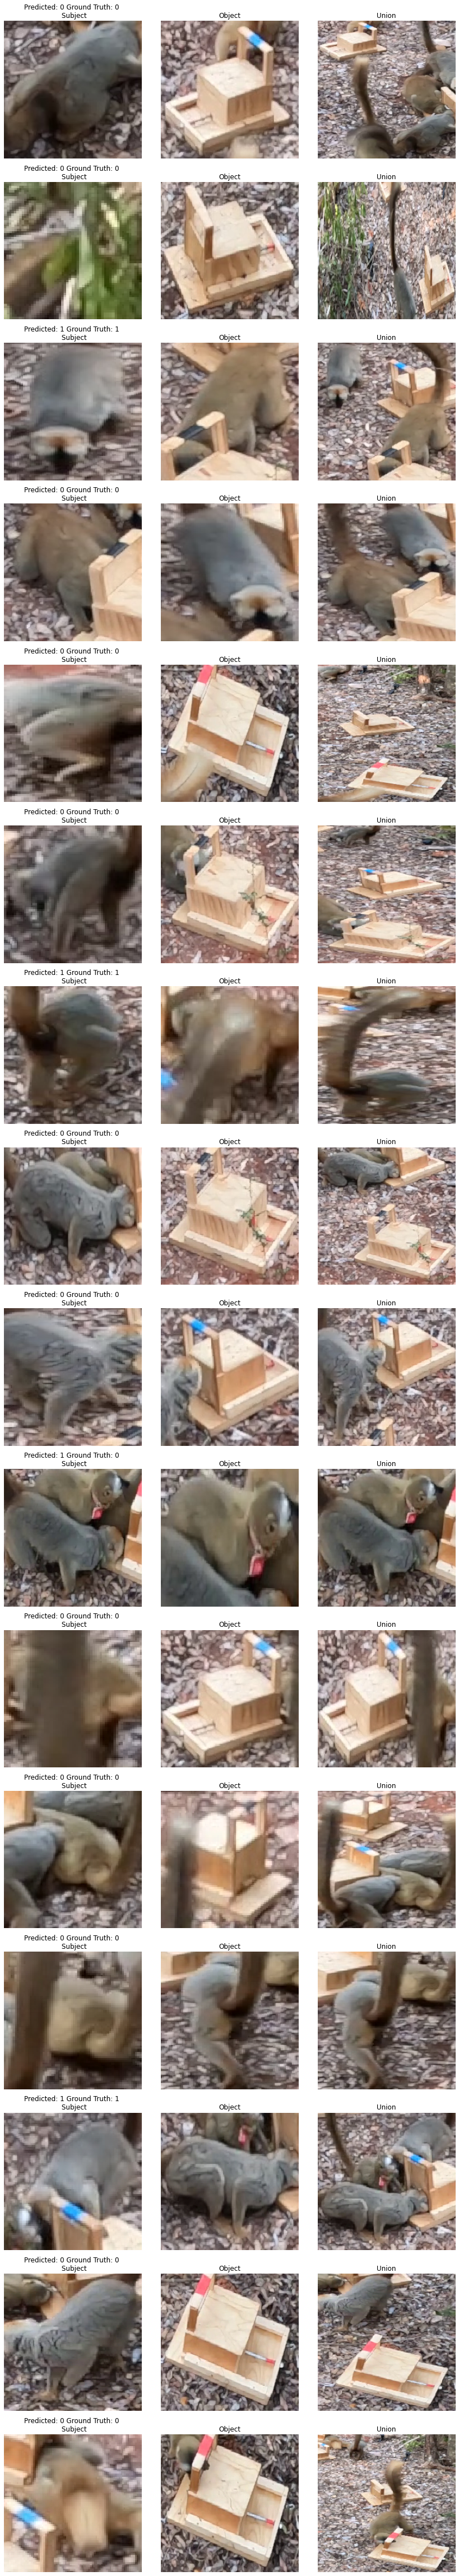

In [13]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model
loaded_model = models.InteractionDetection()
loaded_model.load_state_dict(torch.load("../exp/interactions/first_try/model_epoch_16.pth"))
loaded_model.to(device)

loaded_model.eval()


# Get a batch of data from the validation set
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
data = next(iter(val_dataloader))
subj, obj, union, labels = data['subj'].to(device), data['obj'].to(device), data['union'].to(device), data['label'].to(device)
print(subj.shape, obj.shape, union.shape, labels.shape)

with torch.no_grad():
    # Apply the loaded model to the data
    outputs = loaded_model(subj=subj, obj=obj, union=union)
    _, predicted_labels = torch.max(outputs, 1)

# Convert the predicted labels and ground truth labels to numpy arrays
predicted_labels = predicted_labels.cpu().numpy()
ground_truth_labels = labels.cpu().numpy()


# If the tensors are in the shape (C, H, W), permute them to (H, W, C)
if subj.shape[1] == 3:  # For RGB images
    subj = subj.permute(0, 2, 3, 1)
if obj.shape[1] == 3:  # For RGB images
    obj = obj.permute(0, 2, 3, 1)
if union.shape[1] == 3:  # For RGB images
    union = union.permute(0, 2, 3, 1)

# Convert the tensors to NumPy arrays
numpy_subj = subj.detach().cpu().numpy()
numpy_obj = obj.detach().cpu().numpy()
numpy_union = union.detach().cpu().numpy()

# Plot the images using matplotlib
fig, axes = plt.subplots(len(subj), 3, figsize=(12, 4*len(subj)))

if len(subj) > 1:
    for i in range(len(subj)):
        axes[i, 0].imshow(numpy_subj[i].astype('uint8'))  # Convert to 'uint8' if needed
        axes[i, 0].axis('off')  # Hide the axes

        axes[i, 1].imshow(numpy_obj[i].astype('uint8'))  # Convert to 'uint8' if needed
        axes[i, 1].axis('off')  # Hide the axes
        axes[i, 1].set_title('Object')

        axes[i, 2].imshow(numpy_union[i].astype('uint8'))  # Convert to 'uint8' if needed
        axes[i, 2].axis('off')  # Hide the axes
        axes[i, 2].set_title('Union')

        # Add subtitle showing predicted labels and ground truth
        subtitle = f"Predicted: {predicted_labels[i]} Ground Truth: {ground_truth_labels[i]} \n Subject"
        axes[i, 0].set_title(subtitle, fontsize=12, y=1)
        

else:

    axes[0].imshow(numpy_subj[0].astype('uint8'))  # Convert to 'uint8' if needed
    axes[0].axis('off')  # Hide the axes
    axes[0].set_title('Subject')

    axes[1].imshow(numpy_obj[0].astype('uint8'))  # Convert to 'uint8' if needed
    axes[1].axis('off')  # Hide the axes
    axes[1].set_title('Object')

    axes[2].imshow(numpy_union[0].astype('uint8'))  # Convert to 'uint8' if needed
    axes[2].axis('off')  # Hide the axes
    axes[2].set_title('Union')

    # Add subtitle showing predicted labels and ground truth
    subtitle = f"Predicted: {predicted_labels[0]} Ground Truth: {ground_truth_labels[0]}"
    fig.suptitle(subtitle, fontsize=12, y=1)

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
loaded_model.eval()

# Create empty lists to store the predicted labels and ground truth labels
predicted_labels = []
ground_truth_labels = []

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the validation dataloader
    for data in val_dataloader:
        # Move the data to the device
        subj, obj, union, labels = data['subj'].to(device), data['obj'].to(device), data['union'].to(device), data['label'].to(device)
        
        # Apply the loaded model to the data
        outputs = loaded_model(subj=subj, obj=obj, union=union)
        
        # Calculate the predicted labels
        _, predicted = torch.max(outputs, 1)
        
        # Convert the predicted labels and ground truth labels to numpy arrays
        predicted_labels.extend(predicted.cpu().numpy())
        ground_truth_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
confusion_mat = confusion_matrix(ground_truth_labels, predicted_labels)

print(confusion_mat)

[[204  18]
 [ 55 167]]
